MSE: 15177027.903423928


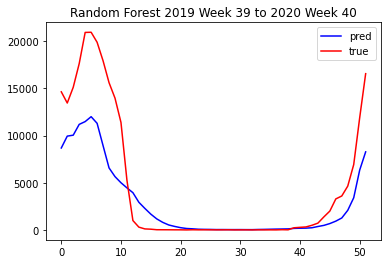

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import utils
import matplotlib.pyplot as plt
import numpy as np

datafile = 'preprocessed_data.csv'

window_size = 2
start = 2010
end = 2019
end_train = end - (window_size)*2
start_test = end_train + window_size
end_test = start_test

train_X, train_y, X_mean, X_std = utils.get_data(start, end_train, datafile)
test_X, test_y, _, _ = utils.get_data(start_test, end_test, datafile)

train_X = ( train_X - X_mean ) / X_std
test_X = ( test_X - X_mean ) / X_std

rf = RandomForestRegressor(n_estimators=300, bootstrap=False)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)

weeks = [i for i in range(52)]
# for i,year in enumerate(range(2010, 2015)):
#     plt.plot(weeks, train_y[i], label=year+5)
# plt.legend()
print(f"MSE: {mean_squared_error(pred_y, test_y)}")
# compare test_y and pred_y
plt.plot(weeks, pred_y[0], label="pred", color="blue")
plt.plot(weeks, test_y[0], label="true", color="red")
plt.title(f"Random Forest {end} Week 39 to {end+1} Week 40")
plt.legend()


In [20]:
# randomized search below

from pprint import pprint

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [22]:
'''
How do we know where to start? A good place is the documentation on the random forest in Scikit-Learn.
This tells us the most important settings are the number of trees in the forest (n_estimators) and the
number of features considered for splitting at each leaf node (max_features).
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)
'''
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_X, train_y)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_X, train_y)
base_accuracy = evaluate(base_model, test_X, test_y)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_X, test_y)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model Performance
Average Error: 2427.0154 degrees.
Accuracy = -486.26%.
Model Performance
Average Error: 2554.3256 degrees.
Accuracy = -513.06%.
Improvement of 5.51%.


In [24]:
results = rf_random.cv_results_
n_top = 5
for i in range(1, n_top + 1):
    candidates = np.flatnonzero(results['rank_test_score'] == i)
    for candidate in candidates:
        print("Model with rank: {0}".format(i))
        print("Mean validation score: {0:.3f} (std: {1:.3f})"
                .format(results['mean_test_score'][candidate],
                        results['std_test_score'][candidate]))
        print("Parameters: {0}".format(results['params'][candidate]))
        print("")

Model with rank: 1
Mean validation score: -47.472 (std: 35.500)
Parameters: {'n_estimators': 311, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

Model with rank: 2
Mean validation score: -49.658 (std: 37.462)
Parameters: {'n_estimators': 1788, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}

Model with rank: 3
Mean validation score: -50.147 (std: 37.451)
Parameters: {'n_estimators': 944, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}

Model with rank: 4
Mean validation score: -50.414 (std: 37.719)
Parameters: {'n_estimators': 1366, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}

Model with rank: 5
Mean validation score: -50.678 (std: 38.045)
Parameters: {'n_estimators': 944, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto',